#### Control de Lectura 2

#### Control de Lectura 2

##### Parte 1

Programe una función que grafique bounding boxes con el label y score de confianza de la predicción. completelo para que pueda mostrar los bounding boxes y el nombre de la clase. Puede usar el "referencia.png" como inspiración del resultado final.

In [37]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

# TODO: Funcion que grafica bounding boxes, labels y scores

def anotar(img_rgb: cv2.typing.MatLike, boxes: np.ndarray, scores: np.ndarray, labels: np.ndarray,
           class_names: dict[int, str]):
    
    img_draw = img_rgb.copy()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.astype(int)
        # Draw rectangle
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), color=(0, 0, 0), thickness=4)
        # Prepare label text
        class_id = int(labels[i])
        class_name = class_names[class_id] if isinstance(class_names, dict) else class_names[class_id]
        score = scores[i]
        label_text = f"{class_name}: {score:.2f}"
        print(label_text)
        # Put label text above the box
        cv2.putText(img_draw, label_text, (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    

    # Mostrar imagen con detecciones
    plt.imshow(img_draw)
    plt.title("Detecciones")
    plt.axis('off')
    plt.show()

In [38]:
import cv2
from ultralytics import YOLO


def ejecutarYOLO(img_str: str) -> None:
    # Cargar modelo YOLOv8 (n -> nano para mayor velocidad)
    model = YOLO('yolov8n.pt') # "en teoria" esto descarga el modelo

    img_path = img_str
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Hacer predicción
    results = model(img_rgb)

    # Extraer cajas, clases y confianza
    boxes = results[0].boxes.xyxy.cpu().numpy()      # Bounding boxes (x1, y1, x2, y2)
    scores = results[0].boxes.conf.cpu().numpy()     # Confianza
    labels = results[0].boxes.cls.cpu().numpy()      # Clases (índices)
    class_names = model.names                              # Diccionario id → nombre

    # Imagen original sin modificar
    plt.imshow(img_rgb)
    plt.title("Imagen original")
    plt.axis('off')
    plt.show()

    anotar(img_rgb, boxes, scores, labels, class_names)


0: 384x640 7 cars, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


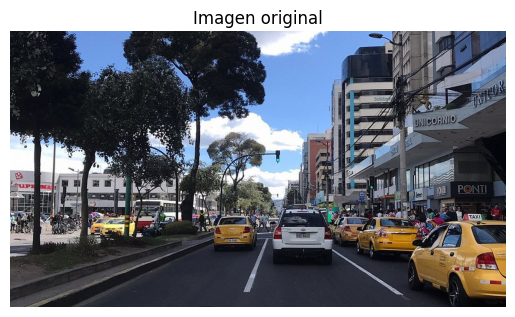

car: 0.91
car: 0.85
car: 0.81
car: 0.73
car: 0.67
car: 0.46
car: 0.25


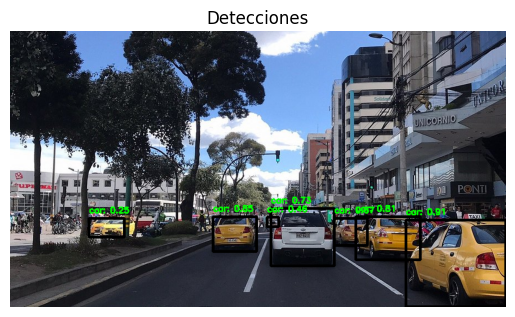

In [39]:
ejecutarYOLO("Av_Amazonas.jpg")

##### Parte 2
Llame a la misma funcion con una imagen de su elección. Analice el resultado, que clases se están prediciendo? Que clases no se están prediciendo?


0: 448x640 15 persons, 4 cars, 1 bench, 9.6ms
Speed: 1.1ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


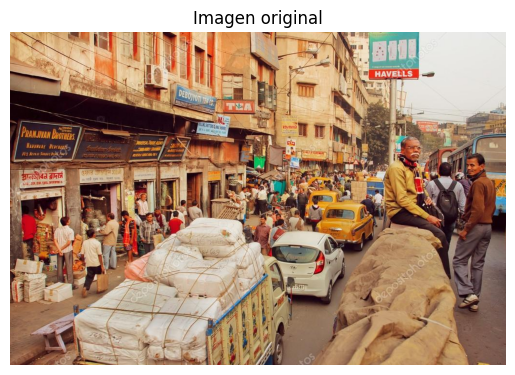

car: 0.88
car: 0.83
person: 0.83
person: 0.73
person: 0.72
person: 0.70
car: 0.66
person: 0.64
person: 0.63
person: 0.55
person: 0.53
person: 0.47
person: 0.47
person: 0.44
car: 0.41
person: 0.36
person: 0.34
person: 0.33
bench: 0.27
person: 0.25


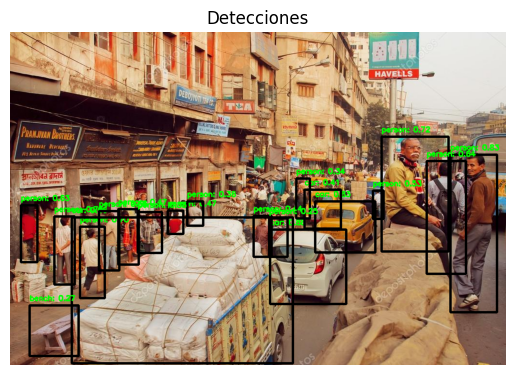

In [40]:
ejecutarYOLO("multitud.jpg")

En la primera imagen, el modelo de detección presenta un desempeño preciso en la identificación de vehículos, sin embargo, omite la detección de peatones. En la segunda imagen se observa una mejora significativa en la detección de personas, así como la inclusión de objetos adicionales como un banco, lo cual indica una mayor cobertura de clases. Las métricas de precisión obtenidas son satisfactorias. Se evidencia una correlación entre el tamaño de la imagen y la precisión del modelo: a mayor resolución, se incrementa la precisión de detección, mientras que a resoluciones más bajas, la capacidad del modelo para identificar objetos disminuye notablemente.

#### Parte 3
Compare el resultado de la clasificación obtenida con SSD vs YOLO. Hay diferencias?

In [41]:
import torch
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.io import read_image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def ejecutarSSD(img_str: str, CONF_THRESHOLD=0.4) -> None:
    # Usar GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Cargar modelo SSD preentrenado
    weights = SSD300_VGG16_Weights.COCO_V1
    class_names = weights.meta['categories']
    model = ssd300_vgg16(weights=SSD300_VGG16_Weights).to(device)
    model.eval()

    # Transformaciones necesarias para SSD
    transform = weights.transforms()

    # Aplicar transformaciones
    img_pil = Image.open("Av_Amazonas.jpg")
    img_rgb = img_pil.convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Inferencia
    with torch.no_grad():
        output = model(img_tensor)[0]

    # Umbral de confianza mínimo
    CONF_THRESHOLD = 0.4

    # Obtener cajas, etiquetas, puntuaciones
    boxes = output['boxes'].cpu().numpy()
    scores = output['scores'].cpu().numpy()
    labels = output['labels'].cpu().numpy()

    # Solo mantener las mas importantes
    mask = scores >= CONF_THRESHOLD
    boxes  = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    plt.imshow(img_rgb)
    plt.title("Imagen original")
    plt.axis('off')
    plt.show()
    # Dibujo de cajas

    img_bgr = np.array(img_rgb)[:, :, ::-1].copy()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    anotar(img_rgb, boxes, scores, labels, class_names)
    

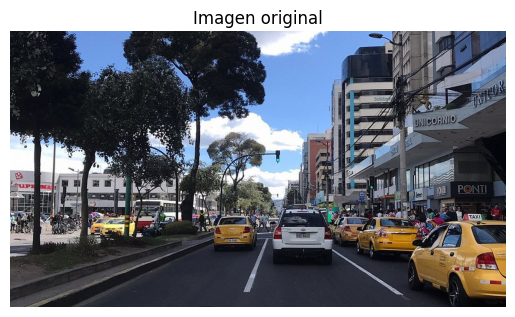

car: 0.86
car: 0.84
car: 0.79
car: 0.66
car: 0.62


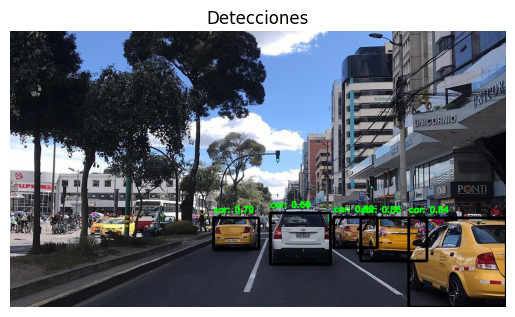

In [42]:
ejecutarSSD('Av_Amazonas.jpg', 0.2)

Se identifican diferencias significativas entre los modelos YOLO y SSD tanto en precisión como en desempeño computacional. En la primera comparación, YOLO demuestra una mayor precisión en la detección de objetos en comparación con SSD, especialmente en la identificación de vehículos y personas. Esta superioridad se refleja en una mejor capacidad de localización y clasificación de objetos.

Una segunda diferencia notable se encuentra en la calidad de las cajas delimitadoras. En YOLO, las bounding boxes presentan una alineación más precisa con los contornos reales de los objetos, mientras que en SSD se observa un desfase en las cajas, con formas menos ajustadas y desviaciones angulares que afectan la exactitud espacial de la detección.

Finalmente, se destaca una diferencia considerable en el tiempo de inferencia: YOLO procesa las imágenes en aproximadamente 0.5 segundos, mientras que SSD requiere alrededor de 2.2 segundos por imagen. Esta diferencia impacta directamente en el rendimiento en tiempo real, siendo YOLO más eficiente en entornos con restricciones de latencia y capacidad computacional, mientras que SSD representa un mayor consumo de recursos en sistemas embebidos o de bajo rendimiento.